In [70]:
import numpy as np
import pandas as pd
from pprint import pprint
from os import listdir
from os.path import isfile, join
from sklearn.model_selection import StratifiedKFold
from scipy import stats
import numpy as np
from sklearn import linear_model, svm
import re
from sklearn.metrics import roc_curve, auc,f1_score



#n_features = [100,200,300,400,500,600,700,800,900,1000,2000,3000,4000,5000,6000,7000,8000,9000,10000,11000,12000,13000,14000,15000,16000,17000,18000,19000,20000,21000,22000,23000,24000,25000,26000,27000,28000,29000,30000]
n_features = [100,200,300,400,500,600,700,800,900,1000]
n_features.sort()
s = "../braindata/data_3_conn_select_100.csv"

lr_all_feature=[]
svm_all_feature=[]
lr_fls_feature=[]
svm_fls_feature=[]

for i in n_features:
    lr_all_accs = []
    lr_all_scores = []
    lr_f1s = []
    svm_all_accs = []
    svm_all_scores = []
    svm_f1s = []
    base_labels = []
    #lr_accuracies = []
    #svm_accuracies = []
    
    replaced = re.sub('100', str(i), s)
    #print(replaced)
    dd =pd.read_csv(replaced,header=0)
    data=np.array(dd)
        #print(data.shape)
    idx_IN_columns = np.append(np.array([3,4]),np.array(range(11,data.shape[1])))
    features=data[:,idx_IN_columns]
        #features=data[:,11:data.shape[1]]
        #features = features.transpose()
    features = stats.zscore(features)
        #print(features.shape)
    y=data[:,6]
        #print(y)
   # print(y.shape)
        #5: ad-smi / 6:mci-smi / 7:adonly-smi / 8:ad-mci / 9:adonly-mci / 10:adonly - adwithsmallvv

    ind_num=np.isnan(y)
       # print(ind_num.shape)
    y_no_nan = y[~ind_num]
    features_no_nan = features[~ind_num,:]

       # print(y.shape)

    y=y_no_nan
    features=features_no_nan
    

    for runs in range(100):
        lr_accuracies = []
        lr_scores = []
        svm_accuracies = []
        svm_scores = []
        strat_labels = []

        logistic = linear_model.LogisticRegression(C=1e5)
        rbf = svm.SVC(C=10,kernel='linear',gamma=0.01)

        skf = StratifiedKFold(n_splits=10)

        for train_index, test_index in skf.split(features, y):
                    train_data, test_data = features[train_index], features[test_index]
                    train_labels, test_labels = y[train_index], y[test_index]

                    strat_labels = np.append(strat_labels, test_labels)

                    log = logistic.fit(train_data, train_labels)
                    log_prob = log.decision_function(test_data)
                    log_acc = log.score(test_data, test_labels)

                    #f1 calculation
                    y_pred = logistic.predict(test_data)
                    log_f1 = f1_score(test_labels, y_pred)


                    rbf = rbf.fit(train_data, train_labels)
                    svm_acc = rbf.score(test_data, test_labels)
                    svm_prob = rbf.decision_function(test_data)

                    #f1 calculation
                    y_pred = rbf.predict(test_data)
                    svm_f1 = f1_score(test_labels, y_pred)
                    #print('SVM Accuracy: %f' % svm_acc)

                    lr_accuracies = np.append(lr_accuracies, log_acc)
                    lr_scores = np.append(lr_scores, log_prob)
                    lr_f1s = np.append(lr_f1s, log_f1)
                    #print('Logistic Regression Accuracy: %f' % log_acc)
                    svm_accuracies = np.append(svm_accuracies, svm_acc)
                    svm_scores = np.append(svm_scores, svm_prob)
                    svm_f1s = np.append(svm_f1s, svm_f1)

                    base_labels = np.append(base_labels, strat_labels)
                    lr_all_scores = np.append(lr_all_scores, lr_scores)
                    lr_fold_avg = np.mean(lr_accuracies)
                    lr_all_accs = np.append(lr_all_accs, lr_fold_avg)
                    svm_all_scores = np.append(svm_all_scores, svm_scores)
                    svm_fold_avg = np.mean(svm_accuracies)
                    svm_all_accs = np.append(svm_all_accs, svm_fold_avg)
                    #print('Logistic Regression Accuracy: %f' % log_acc_avg)
                    #print('SVM Regression Accuracy: %f' % svm_acc_avg)
        #print(max(lr_all_accs))
       # print(max(svm_all_accs))

    lr_all_feature=np.append(lr_all_feature,np.mean(lr_all_accs))
    svm_all_feature=np.append(svm_all_feature,np.mean(svm_all_accs))
    lr_fls_feature=np.append(lr_fls_feature,np.mean(lr_f1s))
    svm_fls_feature=np.append(svm_fls_feature,np.mean(svm_f1s))

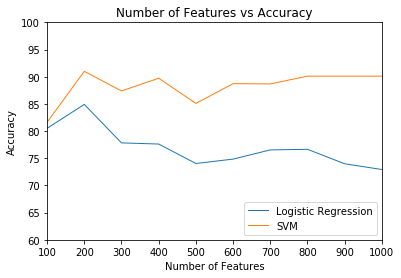

In [75]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(n_features, lr_all_feature*100, lw=1, label='Logistic Regression')
plt.plot(n_features, svm_all_feature*100, lw=1, label='SVM')
plt.xlim([100, 1000])
plt.ylim([60, 100])
plt.xlabel('Number of Features')
plt.ylabel('Accuracy')
plt.title('Number of Features vs Accuracy')
plt.legend(loc="lower right")
#plt.savefig('AD_SMI_Combined.eps')
plt.show()

In [76]:
svm_f1s=svm_f1s[np.nonzero(svm_f1s)]
print(svm_f1s)

print("LR accuracy Avg: {}".format(np.mean(lr_all_feature)))
print("LR accuracy Standard Deviation: {}".format(np.std(lr_all_feature)))

print("LR f1s Avg : {}".format(np.mean( lr_fls_feature)))
print("LR f1s Standard Deviation: {}".format(np.std(lr_f1s)))

print("SVM Avg: {}".format(np.mean(svm_all_feature)))
print("SVM Standard Deviation: {}".format(np.std(svm_all_accs)))

print("SVM f1s Avg : {}".format(np.mean( svm_fls_feature )))
print("SVM f1s Standard Deviation: {}".format(np.std(svm_fls_feature)))
#print(lr_all_accs)

[ 0.93333333  0.93333333  0.92307692  1.          0.92307692  0.92307692
  1.          0.90909091  0.93333333  0.93333333  0.92307692  1.
  0.92307692  0.92307692  1.          0.90909091  0.93333333  0.93333333
  0.92307692  1.          0.92307692  0.92307692  1.          0.90909091
  0.93333333  0.93333333  0.92307692  1.          0.92307692  0.92307692
  1.          0.90909091  0.93333333  0.93333333  0.92307692  1.
  0.92307692  0.92307692  1.          0.90909091  0.93333333  0.93333333
  0.92307692  1.          0.92307692  0.92307692  1.          0.90909091
  0.93333333  0.93333333  0.92307692  1.          0.92307692  0.92307692
  1.          0.90909091  0.93333333  0.93333333  0.92307692  1.
  0.92307692  0.92307692  1.          0.90909091  0.93333333  0.93333333
  0.92307692  1.          0.92307692  0.92307692  1.          0.90909091
  0.93333333  0.93333333  0.92307692  1.          0.92307692  0.92307692
  1.          0.90909091  0.93333333  0.93333333  0.92307692  1.
  0.923076

In [65]:
svm_all_feature

array([ 0.99269577,  0.98539153,  0.98539153,  0.98539153,  0.98539153,
        0.98539153,  0.98539153,  0.98539153,  0.98539153,  0.98539153,
        0.98539153,  0.98539153,  0.98539153,  0.98539153,  0.98539153])

In [66]:
lr_all_feature

array([ 0.99269577,  0.98539153,  0.98539153,  0.98539153,  0.9780873 ,
        0.98539153,  0.97078307,  0.97078307,  0.97078307,  0.97078307,
        0.9780873 ,  0.9780873 ,  0.9780873 ,  0.9780873 ,  0.9780873 ])

In [58]:
 lr_accuracies.shape

(10,)

In [59]:
lr_all_accs.shape

(20,)